In [164]:
import torch
from torch import nn
import torchvision
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import time
import xml.etree.ElementTree as ET
import glob
import random
import shutil
!pip install xmltodict
import xmltodict
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from timeit import default_timer as timer
from typing import Tuple, Dict, List
from PIL import Image
import torchvision
from matplotlib import patches
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_tensor
from matplotlib import patches
from torchvision.utils import make_grid
from torchvision.io import read_image
from tqdm.auto import tqdm
from PIL import Image
from xml.etree import ElementTree as ET
import torchvision.ops as ops
from torchvision.transforms import Compose
try:
    import torchmetrics, mlxtend
    assert int(mlxtend.__version__.split(".")[1]) >= 19
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [165]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [166]:
from google.colab import drive
drive = drive.mount('/content/drive')
data_path = Path("data/")
if data_path.is_dir():
    print("Directory exists.")
else:
    data_path.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile('/content/drive/MyDrive/archive.zip', "r") as zip_ref:
      print("Unzipping")
      zip_ref.extractall(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory exists.


In [167]:
class DataDictionary(Dataset):
  def __init__(self, data_path, transform=None):
      self.images_path = os.path.join(data_path, 'images')
      self.annotations_path = os.path.join(data_path, 'annotations')
      self.images_list = os.listdir(self.images_path)
      self.images_list.sort()
      self.transform = transform
  def __len__(self):
      return len(self.images_list)
  def __getitem__(self, index):
      images = os.path.join(self.images_path, f'maksssksksss{index}.png')
      image = Image.open(images).convert("RGB")
      image = self.transform(image)
      target = {}
      annotations = os.path.join(self.annotations_path, f'maksssksksss{index}.xml')
      tree = ET.parse(annotations)
      root = tree.getroot()
      boxes = []
      labels = []
      for annotations_object in root.findall('object'):
          label = annotations_object.find('name').text
          if label == 'with_mask':
              labels.append(1)
          elif label == 'without_mask':
              labels.append(2)
          elif label == 'mask_weared_incorrect':
              labels.append(3)
          bndbox = annotations_object.find('bndbox')
          xmin = int(bndbox.find('xmin').text)
          ymin = int(bndbox.find('ymin').text)
          xmax = int(bndbox.find('xmax').text)
          ymax = int(bndbox.find('ymax').text)
          boxes.append([xmin, ymin, xmax, ymax])
      boxes = torch.tensor(boxes, dtype=torch.float32)
      labels = torch.tensor(labels)
      target['boxes'] = boxes
      target['labels'] = labels
      return image, target

In [168]:
def to_tuple(batch):
    return tuple(zip(*batch))

In [169]:
to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [170]:
data_folder = '/content/data'
tensor_dataset = DataDictionary(data_folder, transform=to_tensor)
tensor_dataset_dataloader = DataLoader(tensor_dataset, batch_size=4, shuffle=True, num_workers=os.cpu_count(), collate_fn=to_tuple)

In [171]:
image_tensor, target_box_labels = next(iter(tensor_dataset_dataloader))
print("The shape of the input 3 dimensional tensor to the model is: ",image_tensor[0].shape)
print("The input shape of the boxes and labels dictonary: ",target_box_labels[0])

The shape of the input 3 dimensional tensor to the model is:  torch.Size([3, 400, 301])
The input shape of the boxes and labels dictonary:  {'boxes': tensor([[ 94., 198., 189., 327.]]), 'labels': tensor([1])}


In [172]:
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(tensor_dataset, test_size=0.20)
print("Training data size is: ", len(training_data))
print("Testing data size is: ", len(testing_data))

Training data size is:  682
Testing data size is:  171


In [173]:
def training_method(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    training_loss, training_accuracy = 0, 0
    for batch, (images, targets) in enumerate(dataloader):
        images = list([image.to(device) for image in images])
        targets = [{dicts_targets: dict_targets.to(device) for dicts_targets, dict_targets in dicts_of_targets.items()} for dicts_of_targets in targets]
        losses_dicts = model(images, targets)
        losses = sum(loss for loss in losses_dicts.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    training_loss = losses
    training_accuracy = training_accuracy / len(dataloader)
    return training_loss, training_accuracy

In [174]:
def testing_method(model: torch.nn.Module,
              dataloader: None):
  testing_loss, testing_accuracy = 0, 0
  model.eval()
  images, targets = next(iter(dataloader))
  with torch.inference_mode():
    images = list([image.to(device) for image in images])
    outputs = model(images)
  testing_loss = testing_loss / len(dataloader)
  testing_accuracy = testing_accuracy / len(dataloader)
  return testing_loss, testing_accuracy

In [175]:
def train_method(model: torch.nn.Module,
                 training_data_loader: torch.utils.data.DataLoader,
                 testing_data_loader: torch.utils.data.DataLoader,
                 optimizer: torch.optim.Optimizer,
                 loss_function: torch.nn.Module,
                 epochs: None):
  results = {"training_loss": [],"training_accuracy": [],"testing_loss": [],"testing_accuracy": []}
  for epoch in tqdm(range(epochs)):
      training_loss, training_accuracy = training_method(model=model,dataloader=training_data_loader,loss_function=loss_function,optimizer=optimizer)
      testing_loss, testing_accuracy = testing_method(model=model,dataloader=testing_data_loader)
      print(f"For Epoch: {epoch+1} | "f"training_loss: {training_loss} | "f"training_accuracy: {training_accuracy} | "f"testing_loss: {testing_loss} | "f"testing_accuracy: {testing_accuracy}")
      results["training_loss"].append(training_loss)
      results["training_accuracy"].append(training_accuracy)
      results["testing_loss"].append(testing_loss)
      results["testing_accuracy"].append(testing_accuracy)
  return results

In [176]:
def loss_accuracy_plot(results: Dict[str, List[float]]):
    training_loss = results['training_loss']
    testing_loss = results['testing_loss']
    training_accuracy = results['training_accuracy']
    testing_accuracy = results['testing_accuracy']
    epochs = range(len(results['training_loss']))
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='training_loss')
    plt.plot(epochs, testing_loss, label='testing_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, label='training_accuracy')
    plt.plot(epochs, testing_accuracy, label='testing_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [177]:
def plot_image(model, image_path, class_names=['mask_weared_incorrect', 'with_mask', 'without_mask', 'background'], box_score_thresh=0.8):
  img = read_image(image_path)
  img_float = img.float() / 255
  batch = [img_float.to(device)]
  model6.eval()
  with torch.no_grad():
      prediction = model6(batch)[0]
      print(prediction)
  pred_labels = prediction["labels"]
  pred_scores = prediction["scores"]
  pred_boxes = prediction["boxes"][pred_scores >= box_score_thresh]
  pred_labels = pred_labels[pred_scores >= box_score_thresh]
  labels = [class_names[i.item()] for i in pred_labels]
  box = draw_bounding_boxes(img,boxes=pred_boxes,labels=labels,width=5, font_size=15)
  im = to_pil_image(box.detach())
  plt.imshow(im)
  plt.axis('off')
  plt.show()

In [178]:
training_data_loader = DataLoader(training_data, batch_size=1, shuffle=True, num_workers=os.cpu_count(), collate_fn=to_tuple)
testing_data_loader = DataLoader(testing_data, batch_size=1, shuffle=False, num_workers=os.cpu_count(), collate_fn=to_tuple)

In [179]:
class_names = ['mask_weared_incorrect', 'with_mask', 'without_mask', 'background']

In [180]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
model6 = fasterrcnn_resnet50_fpn(weights=weights).to(device)
images, targets = next(iter(training_data_loader))
model6.eval()
with torch.no_grad():
  images = list([image.to(device) for image in images])
  outputs = model6(images)
  print("Lenght of scores and labels before changing the num_classes", len(outputs[0]['boxes']), len(outputs[0]['scores']), len(outputs[0]['labels']))

Lenght of scores and labels before changing the num_classes 32 32 32


In [181]:
num_classes = 4
in_features = model6.roi_heads.box_predictor.cls_score.in_features
model6.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [182]:
summary(model6, input_size=[1, 3, 150, 150])

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

In [124]:
epochs = 30
model6 = fasterrcnn_resnet50_fpn(weights=weights).to(device)
params = [param for param in model6.parameters() if param.requires_grad]
loss_function = nn.CrossEntropyLoss()
model_optimizer =  torch.optim.AdamW(params, lr=0.0001, amsgrad=True)
start_time = timer()
model6_plot = train_method(model=model6,
                           training_data_loader=training_data_loader,
                           testing_data_loader=testing_data_loader,
                           optimizer=model_optimizer,
                           loss_function=loss_function,
                           epochs=epochs)
end_time = timer()
print(f"Total training time for model training and testing: {end_time-start_time} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

For Epoch: 1 | training_loss: 0.40057170391082764 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 2 | training_loss: 0.05486125126481056 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 3 | training_loss: 0.6771385073661804 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 4 | training_loss: 0.06793344020843506 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 5 | training_loss: 0.03182809427380562 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 6 | training_loss: 0.34154295921325684 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 7 | training_loss: 0.20445215702056885 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 8 | training_loss: 0.07424977421760559 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 9 | training_loss: 0.05920140072703361

In [139]:
images, targets = next(iter(training_data_loader))
model6.eval()
with torch.no_grad():
  images = list([image.to(device) for image in images])
  outputs = model6(images)
  print(outputs)

[{'boxes': tensor([[ 73.9010, 205.7433, 180.5772, 328.5923]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}]


{'boxes': tensor([[195.3373, 112.0631, 231.7081, 156.5851],
        [192.8701,  25.7151, 234.9786,  76.0725],
        [ 70.7900, 111.7652, 110.7177, 156.3119],
        [ 77.3716,  25.9534, 119.7069,  76.4965]], device='cuda:0'), 'labels': tensor([1, 1, 2, 2], device='cuda:0'), 'scores': tensor([1.0000, 1.0000, 0.9998, 0.9997], device='cuda:0')}


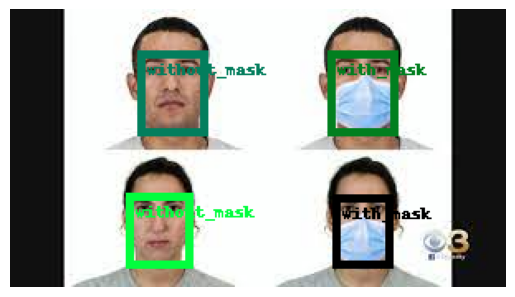

In [145]:
plot_image(model=model6,
          image_path="/content/download (1).jpg")

In [184]:
summary(model7, input_size=[1, 3, 150, 150])

Layer (type:depth-idx)                                  Output Shape              Param #
FCOS                                                    [49, 4]                   --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 7, 7]            --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

In [183]:
from torchvision.models.detection import fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights
weights = FCOS_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
model7 = fcos_resnet50_fpn(weights=weights).to(device)
images, targets = next(iter(training_data_loader))
model7.eval()
with torch.no_grad():
  images = list([image.to(device) for image in images])
  outputs = model7(images)
  print("Lenght of scores and labels before changing the num_classes", len(outputs[0]['boxes']), len(outputs[0]['scores']), len(outputs[0]['labels']))

Lenght of scores and labels before changing the num_classes 100 100 100


In [149]:
epochs = 30
model7 = fcos_resnet50_fpn(num_classes=4).to(device)
params = [param for param in model7.parameters() if param.requires_grad]
loss_function = nn.CrossEntropyLoss()
model_optimizer =  torch.optim.AdamW(params, lr=0.0001, amsgrad=True)
start_time = timer()
model7_plot = train_method(model=model7,
                           training_data_loader=training_data_loader,
                           testing_data_loader=testing_data_loader,
                           optimizer=model_optimizer,
                           loss_function=loss_function,
                           epochs=epochs)
end_time = timer()
print(f"Total training time for model training and testing: {end_time-start_time} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

For Epoch: 1 | training_loss: 1.301582932472229 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 2 | training_loss: 1.2007482051849365 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 3 | training_loss: 1.4583425521850586 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 4 | training_loss: 0.9811272621154785 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 5 | training_loss: 0.8985978364944458 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 6 | training_loss: 1.1096233129501343 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 7 | training_loss: 0.9965665936470032 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 8 | training_loss: 0.8946102857589722 | training_accuracy: 0.0 | testing_loss: 0.0 | testing_accuracy: 0.0
For Epoch: 9 | training_loss: 1.09769606590271 | training

In [150]:
images, targets = next(iter(training_data_loader))
model7.eval()
with torch.no_grad():
  images = list([image.to(device) for image in images])
  outputs = model7(images)
  print(outputs)

[{'boxes': tensor([[ 40.7192, 108.8698,  66.3841, 140.0721],
        [303.1793, 129.9789, 330.8093, 159.2342],
        [130.0340, 107.4240, 174.6163, 152.9386],
        [  1.4229, 104.0575,  21.3759, 125.6436],
        [167.2754,  90.4883, 180.0659, 107.9943],
        [ 29.4066,  88.1067,  45.9226, 105.0610],
        [ 83.4766,  84.3680,  95.6835,  96.7425],
        [219.7444,  99.4100, 256.2905, 139.9428],
        [303.1971, 130.0299, 331.0247, 159.2610],
        [ 44.3723, 135.9830,  76.3731, 170.1985],
        [129.1788, 148.7946, 151.9056, 169.9154],
        [ 29.3529,  88.1527,  45.9676, 105.0588]], device='cuda:0'), 'scores': tensor([0.9123, 0.9054, 0.9017, 0.8954, 0.8506, 0.8490, 0.8078, 0.7991, 0.2735,
        0.2671, 0.2210, 0.2151], device='cuda:0'), 'labels': tensor([2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 3], device='cuda:0')}]


{'boxes': tensor([[195.3373, 112.0631, 231.7081, 156.5851],
        [192.8701,  25.7151, 234.9786,  76.0725],
        [ 70.7900, 111.7652, 110.7177, 156.3119],
        [ 77.3716,  25.9534, 119.7069,  76.4965]], device='cuda:0'), 'labels': tensor([1, 1, 2, 2], device='cuda:0'), 'scores': tensor([1.0000, 1.0000, 0.9998, 0.9997], device='cuda:0')}


/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:232: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


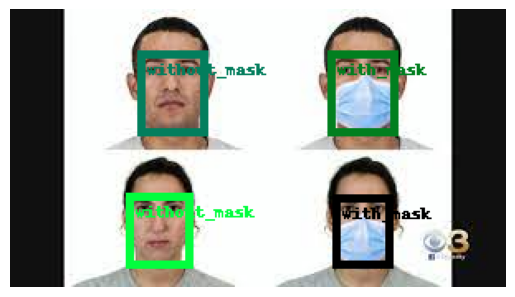

In [151]:
plot_image(model=model7,
          image_path="/content/download (1).jpg")

In [ ]:
Refrences:
https://www.learnpytorch.io/
https://pytorch.org/vision/stable/auto_examples/plot_transforms_v2_e2e.html#sphx-glr-auto-examples-plot-transforms-v2-e2e-py
https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#instance-seg-output
https://www.kaggle.com/code/daniel601/pytorch-fasterrcnn